Look at sample lifetimes and under stand some numbers that we might expect if everything works 'well'.

In [1]:
import sys, os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt
import numpy as np

from hep_tables import xaod_table, make_local
from func_adl import EventDataset

from data import get_ds

In [2]:
ds = get_ds(mH=125, mS=35, lifetime=5, campaign='mc16e')
assert len(ds) == 1
ds

,mH,mS,Lifetime,MCCampaign,RucioDSName,Use,Comments
18,125,35,5,mc16e,mc16_13TeV.311312.MadGraphPythia8EvtGen_A14NNP...,1,NaN


In [3]:
dataset = EventDataset(f'localds://mc16_13TeV:{ds["RucioDSName"].values[0]}')
df = xaod_table(dataset)

In [4]:
truth = df.TruthParticles('TruthParticles')
llp_truth = truth[truth.pdgId == 35]

In [5]:
n_llp = make_local(llp_truth.Count())

In [6]:
n_llp

array([2, 2, 2, ..., 2, 2, 2])

In [7]:
llp_good_truth = llp_truth[llp_truth.hasProdVtx & llp_truth.hasDecayVtx]

In [8]:
lx_prod = make_local(llp_good_truth.prodVtx.x)
ly_prod = make_local(llp_good_truth.prodVtx.y)
lz_prod = make_local(llp_good_truth.prodVtx.z)

In [9]:
lx_decay = make_local(llp_good_truth.decayVtx.x)
ly_decay = make_local(llp_good_truth.decayVtx.y)
lz_decay = make_local(llp_good_truth.decayVtx.z)

In [10]:
lx = lx_decay - lx_prod
ly = ly_decay - ly_prod
lz = lz_decay - lz_prod

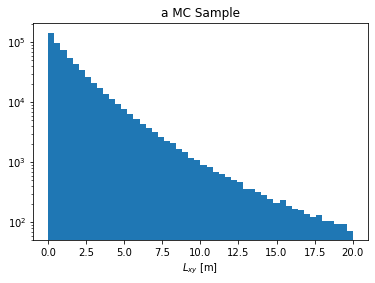

In [18]:
plt.hist(np.sqrt(lx*lx + ly*ly).flatten()/1000.0, bins=50, range=(0,20))
plt.yscale('log')
plt.xlabel('$L_{xy}$ [m]')
_ = plt.title('a MC Sample')

And the sensitvity of the old analyses: